<a href="https://colab.research.google.com/github/t-feldman/github-slideshow/blob/main/20210608_DEGAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction - 20210608 - Infected/Exposed
The purpose of this notebook is to visualize differentially expressed genes from each cell type and find the overlaps between cell types. It will also be used to attach gene metadata to each table and run enrichment analysis.

## Set up
This section installs and load packages and mounts the Google drive

In [ ]:
## Package for retrieving gene annotations
!pip install pybiomart
!pip install gseapy

In [ ]:
## Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pybiomart import Server
from pybiomart import Dataset
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.patches as mpatches
import gseapy as gp

Creating directory /root/.config/bioservices 


## Retrieve annotations

In [ ]:
## Connect to biomart and pull desired attributes from human database using query
dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://asia.ensembl.org')
dataset.attributes
df_annotations = (dataset.query(attributes=['ensembl_gene_id', 'external_gene_name','description','gene_biotype']))
df_annotations = df_annotations.set_index("Gene stable ID")
df_annotations.head()

,Gene name,Gene description,Gene type
Gene stable ID,,,
ENSG00000210049,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...,Mt_tRNA
ENSG00000211459,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...,Mt_rRNA
ENSG00000210077,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...,Mt_tRNA
ENSG00000210082,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...,Mt_rRNA
ENSG00000209082,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...,Mt_tRNA


## Upload datasets
Upload DEG lists for each cell type

In [ ]:
## Read csv files of count data of choice. Store as dictionary for ease.
def csv_to_dict(current_dict, pre_filepath, suf_filepath,celltypes,cell_label):
  for cell in celltypes:
    if cell_label: # if file name has cell type as a prefix
      current_path = prefix_filepath + "/" + cell + "/" + cell + suffix_filepath
    else:
      current_path = pre_filepath + "/" + cell + "/"+ suf_filepath #construct filepath
    current_df = pd.read_csv(current_path, index_col=0) #read data
    current_df.index.name = 'Gene stable ID'
    current_dict[cell] = current_df #store data as value in key cell
  return current_dict
## may consider making some version that will read in multiple csv files 
## and store as nested dictionary

In [ ]:
## Read csv files of DEGs to dataframe for each cell type. Store as dictionary for ease.
celltype_list = ['ProE','BasE','PolyE','OrthoE']
DEG_dict = {}
rlog_dict = {}
prefix_filepath = '/content/drive/Shareddrives/Egan Lab/Tamar/20210607_RNASeq_Analysis'
suffix_filepath = 'Infected(GFP+)vsExposed(GFP-)_WaldTest.csv'
DEG_dict = csv_to_dict(DEG_dict, prefix_filepath,suffix_filepath,celltype_list,False)
## Read csv files of rlog transformed counts for each cell type.
rlog_dict = {}
suffix_filepath = '_RlogCountsWald.csv'
rlog_dict = csv_to_dict(rlog_dict,prefix_filepath,suffix_filepath,celltype_list,True)
rlog_dict['OrthoE'].head()

,Exposed(GFP-)_1,Exposed(GFP-)_2,Exposed(GFP-)_3,Infected(GFP+)_1,Infected(GFP+)_2,Infected(GFP+)_3,Mock(dead_parasite)_1,Mock(dead_parasite)_2,Mock(dead_parasite)_3,Mock(media)_1,Mock(media)_2,Mock(media)_3
Gene stable ID,,,,,,,,,,,,
ENSG00000227232,2.768467,2.575623,2.620411,2.527590,2.865971,2.716599,2.776644,2.811338,2.765334,3.054364,3.544210,2.544283
ENSG00000279928,1.660612,1.661260,1.666342,2.502871,1.658728,1.662138,1.659274,1.704438,1.661332,2.088157,2.186369,1.668785
ENSG00000228463,3.379811,2.863774,2.995897,5.382844,5.253617,5.411705,2.873013,2.853833,3.269599,2.941271,2.744617,3.219319
ENSG00000230021,2.597650,2.806744,2.319256,2.667900,2.403304,2.391807,2.476289,2.435475,2.474216,2.314637,2.314422,2.704454
ENSG00000225630,5.332156,5.282382,5.104911,5.272826,5.179453,5.617165,5.442349,5.243673,5.575443,5.835032,5.812722,5.354317


In [ ]:
## add condition as multindex
def make_column_list(column_list):
  name_list = []
  for column in column_list:
    if "Exposed" in column:
      name_list.append("Exposed(GFP-)")
    elif "Inf" in column:
      name_list.append("Infected(GFP+)")
    elif "dead" in column:
      name_list.append("Mock(dead_parasite)")
    else:
      name_list.append("Mock(media)")

  return name_list
def add_metadata(current_dict):
  for key in current_dict:
    name_list = make_column_list(current_dict[key].columns)
    x = pd.MultiIndex.from_tuples(zip(current_dict[key].columns, name_list))
    x.names = ['sample','condition']
    current_dict[key].columns = x
  return current_dict
rlog_dict = add_metadata(rlog_dict)
rlog_dict['ProE']


sample,ProE_Exposed(GFP-)_1,ProE_Exposed(GFP-)_2,ProE_Exposed(GFP-)_3,ProE_Infected(GFP+)_1,ProE_Infected(GFP+)_2,ProE_Infected(GFP+)_3,ProE_Mock(dead_parasite)_1,ProE_Mock(dead_parasite)_2,ProE_Mock(dead_parasite)_3,ProE_Mock(media)_1,ProE_Mock(media)_2,ProE_Mock(media)_3
condition,Exposed(GFP-),Exposed(GFP-),Exposed(GFP-),Infected(GFP+),Infected(GFP+),Infected(GFP+),Mock(dead_parasite),Mock(dead_parasite),Mock(dead_parasite),Mock(media),Mock(media),Mock(media)
Gene stable ID,,,,,,,,,,,,
ENSG00000227232,3.624820,3.660606,3.694792,3.850802,3.842759,3.753368,3.763763,3.719964,3.714698,3.659498,3.653739,3.625681
ENSG00000241860,3.800414,3.906198,3.958129,3.798015,4.063339,4.101613,3.783755,3.919979,3.842273,3.884846,3.923417,3.935875
ENSG00000279457,4.148689,4.025242,4.048132,3.957790,4.084475,4.128505,3.913389,4.032206,4.023848,3.913478,3.967620,4.035557
ENSG00000228463,5.981825,6.110365,6.304953,6.260455,6.312861,7.123426,6.279493,6.119247,6.182068,6.251432,6.160947,6.156736
ENSG00000237094,4.720884,4.787690,4.784860,4.780429,5.107521,4.930215,4.606760,4.726501,4.766743,4.784914,4.645069,4.800581
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000210196,8.666612,8.401704,8.908101,8.667923,8.868034,9.111022,8.055910,8.402373,8.567036,8.108021,8.367900,8.521927
ENSG00000278673,3.802388,3.743346,3.936447,3.985400,4.020677,3.888343,3.761001,3.817377,3.813852,3.865558,3.944054,3.809661


## Attach annotations
This section is for attaching gene information to a dataframe where rows are genes and the index column is an Ensembl gene id

In [ ]:
## function to attach dataframe of gene annotations to each dataframe in a 
## dictionary of dataframes where the index column of both is labeled "Gene stable ID"
def attach_annotations(current_dict,annotation_df):
  for key in current_dict:
    print(key + " dimensions before: " + str(current_dict[key].shape))
    current_dict[key] = (pd.merge(left = current_dict[key], right = annotation_df, how = 'left', 
          on='Gene stable ID', sort=False, validate = "1:1"))
    print(key + " dimensions after: " + str(current_dict[key].shape))
  return current_dict

In [ ]:
## Attach annotations to DEG dataframes and rlog dataframes
DEG_annotation_dict = DEG_dict.copy()
DEG_annotation_dict = attach_annotations(DEG_annotation_dict,df_annotations)

## make a copy to attach annotations so that column don't clash later
rlog_annotation_dict = rlog_dict.copy()
rlog_annotation_dict = attach_annotations(rlog_annotation_dict,df_annotations)

ProE dimensions before: (18124, 7)
ProE dimensions after: (18124, 10)
BasE dimensions before: (17500, 7)
BasE dimensions after: (17500, 10)
PolyE dimensions before: (16154, 7)
PolyE dimensions after: (16154, 10)
OrthoE dimensions before: (12141, 7)
OrthoE dimensions after: (12141, 10)
ProE dimensions before: (18124, 12)
ProE dimensions after: (18124, 15)
BasE dimensions before: (17500, 12)


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


BasE dimensions after: (17500, 15)
PolyE dimensions before: (16154, 12)
PolyE dimensions after: (16154, 15)
OrthoE dimensions before: (12141, 12)
OrthoE dimensions after: (12141, 15)


## Filter DEG for significant genes
This section filters the DEG dataframes by their adjusted p-value and produces rlog dataframe of counts for significant genes

In [ ]:
## filter by padj and store in new dictionary
padj = 0.01
DEG_sig_dict = {}
for key in DEG_dict:
  print(key + " dimensions before: " + str(DEG_dict[key].shape))
  # filter each dataframe by padj =< padj value set above. Sort the dataframe by padj
  DEG_sig_dict[key] = (DEG_dict[key][DEG_dict[key]['padj'] <= padj].
                       sort_values(by=['padj']))
  print(key + " dimensions after: " + str(DEG_sig_dict[key].shape))
DEG_sig_annotation = DEG_sig_dict.copy()
DEG_sig_annotation = attach_annotations(DEG_sig_annotation,df_annotations)

ProE dimensions before: (1083, 7)
ProE dimensions after: (1083, 10)
BasE dimensions before: (628, 7)
BasE dimensions after: (628, 10)
PolyE dimensions before: (1794, 7)
PolyE dimensions after: (1794, 10)
OrthoE dimensions before: (1585, 7)
OrthoE dimensions after: (1585, 10)


In [ ]:
## This section is used to filter significant genes by whether they are up or down
DEG_updown = {}
for key in DEG_sig_annotation:
  # store up and down dataframes as list [up,down]
  DEG_updown[key] = ([DEG_sig_annotation[key][DEG_sig_annotation[key]['log2FoldChange'] > 0], 
                      DEG_sig_annotation[key][DEG_sig_annotation[key]['log2FoldChange'] < 0]])


In [ ]:
## filter rlog counts by DEG genes and store in new dictionary
rlog_sig_dict = {}
for key in rlog_dict:
  print(key + " dimensions before: " + str(rlog_dict[key].shape))
  idx = rlog_dict[key].index
  # make boolean array of whether rlog index in DEG index and use to filter rlog
  rlog_sig_dict[key] = rlog_dict[key][idx.isin(DEG_sig_dict[key].index)]
  print(key + " dimensions after: " + str(rlog_sig_dict[key].shape))

ProE dimensions before: (18124, 12)
ProE dimensions after: (1083, 12)
BasE dimensions before: (17500, 12)
BasE dimensions after: (628, 12)
PolyE dimensions before: (16154, 12)
PolyE dimensions after: (1794, 12)
OrthoE dimensions before: (12141, 12)
OrthoE dimensions after: (1585, 12)


## Produce clustered heatmaps of DEGs

In [ ]:
## Function to create clustered heatmaps with desired conditions

## Filter dataframe of counts according to desired conditions
def make_dataframe(current_dict,condition_list,key):
  selected_df = current_dict[key].loc[:,(slice(None), condition_list)]
  return selected_df
## Make the linkages (clustering) for rows and columns
def custom_dendrogram(current_df):
  dend_col = hc.linkage(current_df.T.values, method="ward",optimal_ordering=True)
  dend_row = hc.linkage(current_df.values,method='ward',optimal_ordering=True)
  return [dend_row,dend_col]
## Make the annotation colors and set up legend
def make_colors(selected_df,condition_list,color_list):
  color_zip = zip(condition_list, color_list)
  current_legend = [mpatches.Patch(color=c, label=l) for l,c in color_zip]
  color_dict = dict(zip(condition_list, color_list))
  col_colors = selected_df.columns.get_level_values('condition').map(color_dict)
  return [col_colors,current_legend]
## Make the clustermap for the current dataframe
def plot_clustermap(selected_df,dend_list,fsize,cmap_options,color_legend,key):
  plt.figure(figsize=fsize)
  current_colormap = sns.color_palette(cmap_options[0], n_colors=cmap_options[1], as_cmap=True)
  g = (sns.clustermap(selected_df, z_score=0, robust=True,
                      yticklabels=False,xticklabels=False, 
                      row_linkage = dend_list[0], col_linkage=dend_list[1], 
                      cmap = current_colormap, cbar_pos=(0.99, .63, .18, .03), 
                      col_colors=color_legend[0], cbar_kws={"orientation":"horizontal"},
                      dendrogram_ratio = (0.1,0.1)))
  l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),
                          handles=color_legend[1],frameon=True)
  l2.set_title(title='Condition',prop={'size':10})
  g.ax_heatmap.invert_yaxis()
  g.ax_row_dendrogram.invert_yaxis()
  g.ax_col_dendrogram.set_title(key+" Infected/Exposed",fontdict={'fontsize':"42"})
  current_filepath = ('/content/drive/Shareddrives/Egan Lab/Tamar/20210607_RNASeq_Analysis/'+
               key + "/" + key + '_ClustermapIEOptimal.svg')
  plt.savefig(current_filepath, bbox_inches='tight',format="svg")
  plt.show()
  plt.close()
  print(current_filepath)
## Make clustermaps for a dictionary of dataframes with cell type as key and save
def clustermap_from_dict(current_dict,condition_list,color_list,fsize,cmap_options):
  for key in current_dict:
    selected_df = make_dataframe(current_dict,condition_list,key)
    dend_list = custom_dendrogram(selected_df)
    color_legend = make_colors(selected_df,condition_list,color_list)
    plot_clustermap(selected_df, dend_list, fsize, cmap_options,color_legend,key)
    print("Done with: "+key)


In [ ]:
## Call function for heatmap creation for all cell types
clustermap_from_dict(rlog_sig_dict,['Infected(GFP+)','Exposed(GFP-)'],['g','m'],(15,15),['coolwarm',80])

# Test Code
This is a block of code to test clustermap formatting

In [ ]:
color_list = zip(["Mock(media)","Mock(dead_parasite)","Exposed(GFP-)","Infected(GFP+)"], ['dimgray','c','m','g'])
lut1 = dict(zip(["Mock(media)","Mock(dead_parasite)","Exposed(GFP-)","Infected(GFP+)"], ['dimgray','c','m','g']))
col_colors = rlog_sig_dict["PolyE"].columns.get_level_values('condition').map(lut1)
col_colors
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in color_list]
plt.figure(figsize=(15,15))
#sns.set_context(font_scale=1.75)
current_colormap = sns.color_palette('coolwarm', n_colors=80, as_cmap=True)
g = (sns.clustermap(rlog_sig_dict['PolyE'],cmap = current_colormap, z_score=0,
                  robust=True,yticklabels=False,xticklabels=False, col_linkage=Z, 
                  cbar_pos=(0.99, .63, .18, .03), col_colors=col_colors, 
                  dendrogram_ratio = (0.1,0.1),cbar_kws={"orientation":"horizontal"},row_linkage=None))
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
l2.set_title(title='Condition',prop={'size':10})
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.set_title("PolyE",fontdict={'fontsize':"36"}) 
plt.savefig('/content/drive/Shareddrives/Egan Lab/Tamar/20210607_RNASeq_Analysis/test_figure2.svg', bbox_inches='tight',format="svg")

In [ ]:
DEG_updown['PolyE'][]

(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)

# List all DEGs across cell type

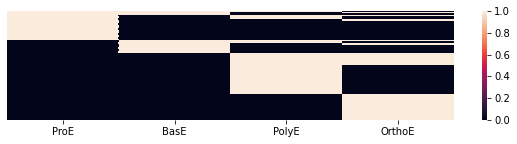

In [ ]:

combined_idx = pd.Index([])
for key in rlog_sig_dict:
  combined_idx = combined_idx.union(rlog_sig_dict[key].index)
combined_df = pd.DataFrame(index=combined_idx)
for key in rlog_sig_dict:
  combined_df[key] = [x in rlog_sig_dict[key].index for x in combined_idx ]
combined_df = combined_df.astype(int)
combined_df = combined_df.sort_values(by = celltype_list,ascending=False)
plt.figure(figsize=(10,2))
ax = sns.heatmap(combined_df,yticklabels=False)


## GSEA analysis for list of DEGs

In [ ]:
rlog_sig_annotated = rlog_sig_dict.copy()
rlog_sig_annotated = attach_annotations(rlog_sig_annotated,df_annotations)
glist = DEG_updown['PolyE'][1]['Gene name'].tolist()
names = gp.get_library_name()
gene_sets=['KEGG_2016','KEGG_2013']
glist = [x for x in glist if str(x) != 'nan']

ProE dimensions before: (1083, 12)
ProE dimensions after: (1083, 15)
BasE dimensions before: (628, 12)


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


BasE dimensions after: (628, 15)
PolyE dimensions before: (1794, 12)
PolyE dimensions after: (1794, 15)
OrthoE dimensions before: (1585, 12)
OrthoE dimensions after: (1585, 15)


In [ ]:
enr = gp.enrichr(gene_list=glist,gene_sets=['GO_Biological_Process_2018'],organism='Human',description='test_name', outdir='test/enrichr_kegg',cutoff=0.1)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
98,GO_Biological_Process_2018,negative regulation of histone acetylation (GO...,4/11,0.000942,0.026548,0,0,12.527523,87.284517,CTBP1;SIN3A;BRCA1;SNCA
99,GO_Biological_Process_2018,methionine metabolic process (GO:0006555),4/11,0.000942,0.026548,0,0,12.527523,87.284517,AHCYL1;MTHFD1;SMS;MTR
100,GO_Biological_Process_2018,regulation of carbohydrate catabolic process (...,7/37,0.000983,0.027421,0,0,5.126889,35.504233,NDC1;NUP93;NUP205;NUP188;NUP210;NUP50;TPR
101,GO_Biological_Process_2018,nucleosome disassembly (GO:0006337),5/19,0.001109,0.030338,0,0,7.835821,53.318077,NFE2;SMARCC1;SMARCD2;SMARCC2;SMARCA4
102,GO_Biological_Process_2018,chromatin disassembly (GO:0031498),5/19,0.001109,0.030338,0,0,7.835821,53.318077,NFE2;SMARCC1;SMARCD2;SMARCC2;SMARCA4
...,...,...,...,...,...,...,...,...,...,...
193,GO_Biological_Process_2018,mitotic DNA damage checkpoint (GO:0044773),6/39,0.006575,0.095504,0,0,3.989760,20.046605,FANCI;BLM;MSH2;CDK2;CLSPN;FOXN3
194,GO_Biological_Process_2018,negative regulation of proteasomal protein cat...,5/28,0.006765,0.097761,0,0,4.767384,23.817913,ALAD;BAG6;USP7;RPL11;PSMF1
195,GO_Biological_Process_2018,regulation of microtubule polymerization or de...,4/18,0.006839,0.097835,0,0,6.261468,31.213757,SKA3;SKA1;CLASP1;CLASP2
196,GO_Biological_Process_2018,DNA ligation (GO:0006266),4/18,0.006839,0.097835,0,0,6.261468,31.213757,POLD3;LIG1;PARP2;HMGB2


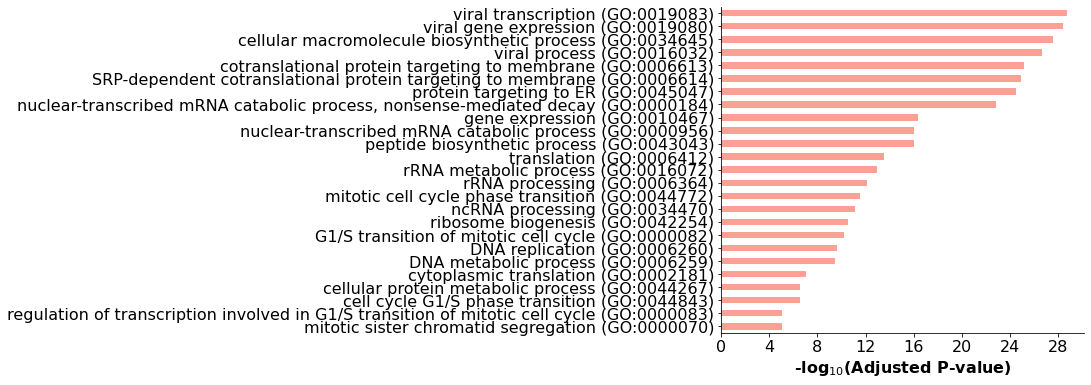

In [ ]:
from gseapy.plot import barplot, dotplot
barplot(enr.results, cutoff=0.1, top_term=25)
enr.results[enr.results['Adjusted P-value'] < 0.1].tail(n=100)